In [3]:
import io
import os
import numpy as np
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import matlab.engine
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, freqs

%matplotlib inline

In [2]:
def flatten(lst):
    """Flatten a list."""  # thank you Tomasi :)
    return [y for l in lst for y in flatten(l)] \
       if isinstance(lst, (list, np.ndarray)) else [lst] 

# Preprocessing blocks 

1) Filters at 50 Hz and harmonics  
2) Wavelet transforms   
3) Highpass filters  

### 50 Hz and harmonics - digital bandstop filter

In [24]:
def filter_50Hz(x, fs=1000., forder=5):
    nyq = fs / 2  # nyquist frequency
    cutoff = 50.  # we want to cut all the multiples of 50 Hz 
    halfwidth = 1.5
    norm_bandstop = cutoff * np.arange(1, nyq / 50)  # here we generate 50 Hz and harmonics
    for f in norm_bandstop:
        b, a = butter(forder, [(f-halfwidth) / nyq, (f+halfwidth) / nyq] , 'bandstop', analog=False)
        x = filtfilt(b, a, x)
    return x

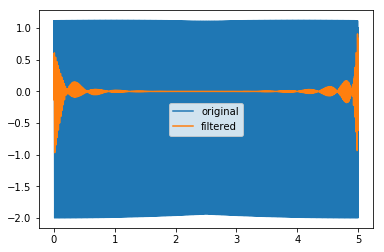

In [28]:
tmin, tmax, points = 0, 5, 5000
f1, f2 = 50., 100.        # signal's frequencies
t = np.linspace(tmin, tmax, points)
x = np.sin(2 * f1 * np.pi * t)
x += np.cos(2 * f2 * np.pi * t)

plt.plot(t, x, label="original");
plt.plot(t, filter_50Hz(x), label="filtered");
plt.legend();
plt.savefig("harmonics.pdf")

** Comments ** edge effects due to filtering are quite strong.   
We cut the init and the final part of the signal, given that there are also artifacts at the beginning of the acquisitions

### Highpass digital filter 

In [4]:
def filter_highpass(x, cutoff, fs=1000., forder=5):
    norm_cutoff = cutoff / (fs / 2)
    b, a = butter(forder, norm_cutoff, 'highpass', analog=False)
    return filtfilt(b, a, x)

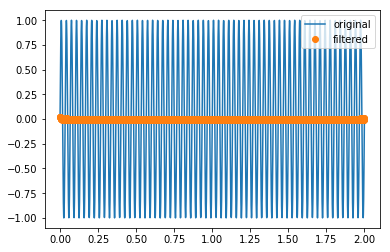

In [20]:
# here we verify if the function works properly

tmin, tmax, points = 0, 2, 2000
f = 30.         # signal's frequency
cutoff = 50.   # cutoff
t = np.linspace(tmin, tmax, points)
x = np.sin(2 * f * np.pi * t)

plt.plot(t, x, label="original");
plt.plot(t, filter_highpass(x, cutoff), 'o', label="filtered");
plt.legend();
plt.savefig("highpass2.pdf")

### Analog filters

Example of **highpass filter**

Example of **bandstop filter**

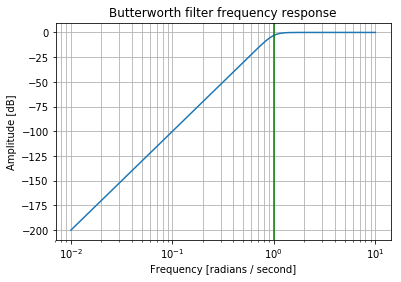

In [15]:
order = 5
cutoff = 1

b, a = butter(order, cutoff, 'highpass', analog=True)
w, h = freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)));
plt.title('Butterworth filter frequency response');
plt.xlabel('Frequency [radians / second]');
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.axvline(cutoff, color='green')  # cutoff frequency

plt.savefig("highpass_analog.pdf")
plt.show()

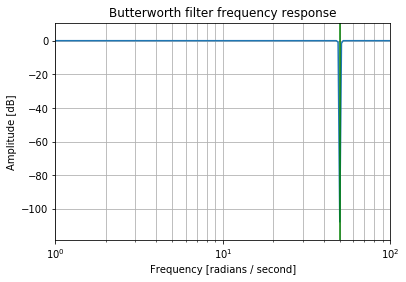

In [16]:
stopf = 50.
order = 4
nyq = 500.

b, a = butter(order, [stopf-1, stopf+1], 'bandstop', analog=True)
w, h = freqs(b, a)
plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(stopf, color='green')  # cutoff frequency
plt.savefig("50hz.pdf")
plt.show()

## CWT given a single recording

In [45]:
def cwt_allscales(x, mins=0.3, maxs=3, ns=100, Ts=1e-3):
    """
    x : signal for which we want to compute the cwt
    mins : minimum scale of the wavelet transform
    maxs : maximum scale of the wavelet transform
    ns : number of scales
    Ts : sampling period
    we fix the mother wavelet to Morlet
    """
    with matlab.engine.start_matlab() as eng:
        scales = matlab.double(list(np.logspace(mins, maxs, ns)))
        x_mat = matlab.double(list(x))
        coefs = np.round(np.asarray(eng.cwt(x_mat, scales, 'cmor1-1', Ts)), decimals=5)
    return coefs

In [81]:
tmin, tmax, points = 0, 2, 2000
f1, f2 = 50., 200.        # signal's frequencies
t = np.linspace(tmin, tmax, points)
x = np.sin(2 * f1 * np.pi * t)
x += np.cos(2 * f2 * np.pi * t)
x += 5 * np.exp(-((t-1)/1e-2)**2)

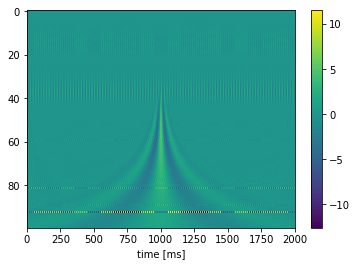

In [75]:
plt.imshow(np.real(cwt_allscales(x)), aspect="auto");
plt.xlabel("time [ms]")
plt.colorbar()

## CWT of all recordings at a fixed scale

In [91]:
mins, maxs, ns = 0.3, 3, 100
scales = np.logspace(mins, maxs, ns)
# morlet_file = "/home/vanessa/DATA_SEEG/central_f_per_scale.mat"
# freqsM = np.ndarray.flatten(loadmat(morlet_file)["f"])

# pick a scale from the scales array
# at the same position in freqsM you will find the corresponding central frequency

def cwt_allrecords(x, scale, Ts=1e-3):
    
    n, s = x.shape
    coefs = np.zeros((n, s), dtype=complex)
    
    with matlab.engine.start_matlab() as eng:
        freq = eng.scal2frq(matlab.double([scale]), 'cmor1-1', Ts)
        print("corresponding frequency: " + str(freq))
        for idx, row in enumerate(x):
            row_mat = matlab.double(list(row))
            coefs[idx] = np.round(np.asarray(eng.cwt(row_mat, matlab.double([scale]), 'cmor1-1', Ts)), decimals=5)
        
    return coefs

# Similarity measures

Here we compute the similarity measures  

1) Amplitude correlation  
2) Phase locking value  

In [38]:
def amp_correlation(x):
    """
    x : matrix of dimension (# recordings, # time points)
    we must give a real input np.abs(wavelet_coefficients)
    """
    return np.corrcoef(x)

In [36]:
def plv(x):
    """
    x : matrix of dimension (# recordings, # time points)
    Given a matrix containing the wavelet transforms at a fixed scale we need
    to compute the phase and then the PLV value
    each row contains the CWT complex coefficients of one time series 
    """
    n, samples = x.shape
    phase = np.arctan2(np.imag(x), np.real(x));
    return np.abs(np.exp(1j * phase).dot(np.exp(-1j * phase.T))) / samples

In [39]:
# dummy example of coefficient matrix
x = np.random.randn(10) + 1j * np.random.randn(10)
x = np.vstack((x, x))  

# plv and amplitude correlations
print(plv(x))          
print(amp_correlation(np.abs(x)))

[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
